# Analysis of CrowdFlower job #767262: sentence-level CID verification task for BioCreative final evaluation

Tong Shu Li<br>
Created on: 2015-08-19<br>
Last updated: 2015-10-22

Here we analyze the sentence-level task of the final evaluation for BioCreative V.

In [1]:
from collections import defaultdict
from IPython.display import Image
import datetime as dt
import matplotlib as plt
import numpy as np
import os
import pandas as pd
import pycountry

In [2]:
NUMPY_RAND_SEED = 993402

In [3]:
matplotlib inline

In [4]:
from src.filter_data import filter_data
from src.aggregate_results import *

In [5]:
def convert_time(text):
    """
    Given the time in CrowdFlower's output format,
    convert it to a Python datetime object.
    CrowdFlower time stamps are in UTC.
    
    CrowdFlower timestamps have the following format:
    
    month/day/year hour:minute:second
    
    Example:
    
    8/2/2015 00:26:24
    """
    return dt.datetime.strptime(text, "%m/%d/%Y %H:%M:%S")

def time_elapsed(start, stop):
    """
    Given two Python datetime objects, determines the number
    of seconds between those two times.
    """
    seconds = int((stop - start).total_seconds())
    assert seconds >= 0
    return seconds

def determine_time_taken(dataframe):
    """
    Given a dataframe with the responses from one worker,
    determines the time taken for one page of work.
    """
    def time_taken_wrapper(row):
        return time_elapsed(row[0], row[1])
    
    if dataframe.empty:
        return pd.Series()
    
    time_taken = dataframe[["_started_at", "_created_at"]].apply(time_taken_wrapper, axis = 1)
    return time_taken

def time_stats(time_series):
    """
    Given the time taken for each individual work unit,
    determines some stats.
    """
    return (time_series.min(), time_series.median(), time_series.max())

def get_country_name(code):
    if isinstance(code, str):
        return pycountry.countries.get(alpha3 = code).name.split(",")[0]
    
    # code is missing (NaN)
    return "unknown"

---

### Worker analysis

In [6]:
loc = "data/crowdflower/results"
fname = "job_767262_worker_summary.csv"
worker_data = pd.read_csv(os.path.join(loc, fname), sep = ',')

In [7]:
# add a column that tells us if a worker was flagged
worker_data["flagged"] = worker_data["flagged_at"].map(lambda x: isinstance(x, str))

In [8]:
worker_data.shape

(356, 19)

In [9]:
worker_data.head()

,worker_id,external_id,judgments_count,missed_count,golds_count,forgiven_count,channel,country,region,city,last_ip,flagged_at,rejected_at,bonus,flag_reason,trust_overall,submission_rate,level_2_contributors,flagged
0,2253549,3174334,6,3,6,0,prodege,CAN,NaN,NaN,70.71.36.231,NaN,NaN,0,NaN,0.5000,360,1,False
1,4688131,DanicaWong,366,2,66,0,zoombucks,CAN,BC,Vancouver,75.157.35.92,NaN,NaN,0,NaN,0.9697,439,1,False
2,6476374,3650690,0,0,0,0,clixsense,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1.0000,0,1,False
3,6508242,3048676,6,1,6,0,clixsense,IND,36,Bareilly,117.212.12.223,NaN,NaN,0,NaN,0.8333,360,1,False
4,6744840,ardann,0,0,0,0,zoombucks,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1.0000,0,1,False


In [10]:
# total workers:
len(worker_data)

356

In [11]:
# zero judgments (gave up immediately?)
len(worker_data.query("judgments_count == 0"))

133

In [12]:
# made at least one judgement
len(worker_data.query("judgments_count > 0"))

223

In [13]:
# saw only the quiz
len(worker_data.query("judgments_count == 6"))

116

In [14]:
# saw some real work (passed initial quiz)
len(worker_data.query("judgments_count > 6"))

107

In [15]:
# saw only the quiz and passed, but did no real work
len(worker_data.query("judgments_count == 6 and trust_overall >= 0.7"))

14

In [16]:
# failed the initial quiz
len(worker_data.query("judgments_count == 6 and trust_overall < 0.7"))

102

In [17]:
# eventually failed out of the job
len(worker_data.query("judgments_count > 6 and trust_overall < 0.7"))

12

In [18]:
# had good trust score but was kicked out due to weird answer distribution
len(worker_data.query("judgments_count > 6 and trust_overall >= 0.7 and flagged"))

5

In [19]:
# had good trust score but was kicked out due to weird answer distribution
good_workers = worker_data.query("judgments_count > 6 and trust_overall >= 0.7 and ~flagged")
print(len(good_workers))

90


### Good worker statistics

In [20]:
good_workers.head()

,worker_id,external_id,judgments_count,missed_count,golds_count,forgiven_count,channel,country,region,city,last_ip,flagged_at,rejected_at,bonus,flag_reason,trust_overall,submission_rate,level_2_contributors,flagged
1,4688131,DanicaWong,366,2,66,0,zoombucks,CAN,BC,Vancouver,75.157.35.92,NaN,NaN,0,NaN,0.9697,439,1,False
6,7281828,4059599,246,5,46,0,clixsense,PHL,D9,Mandaluyong City,121.54.32.144,NaN,NaN,0,NaN,0.8913,369,1,False
8,9509334,2691342,96,4,21,0,clixsense,BIH,01,Sarajevo,188.127.125.187,NaN,NaN,0,NaN,0.8095,360,1,False
11,11034490,A49649E23956D3B82BFA95FAD8D0CB36,30,1,10,0,neodev,PHL,D9,NaN,180.191.114.106,NaN,NaN,0,NaN,0.9000,360,1,False
12,11064916,F3412D40364B0E6F2BFA95FAD8D0CB36,636,17,111,0,neodev,BOL,04,La Paz,190.129.184.198,NaN,NaN,0,NaN,0.8468,250,1,False


In [21]:
good_worker_ids = set(good_workers["worker_id"])

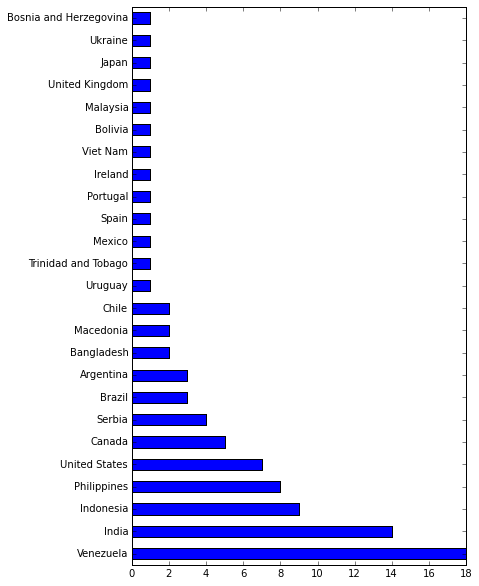

In [22]:
good_workers["country"].map(get_country_name).value_counts().plot(kind = "barh", figsize = (6, 10))

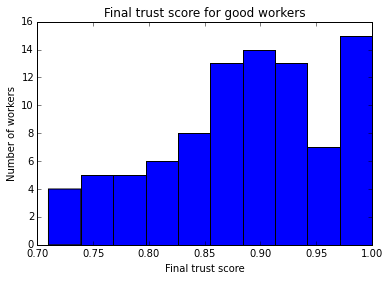

In [23]:
graph = good_workers["trust_overall"].plot(kind = "hist", title = "Final trust score for good workers")
graph.set_ylabel("Number of workers")
graph.set_xlabel("Final trust score")

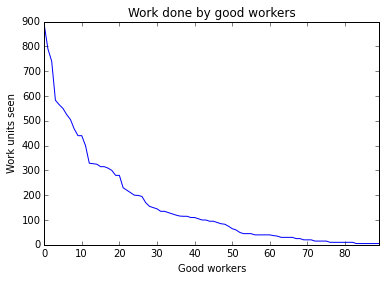

In [24]:
# plot the amount of work done by the good workers
# only count real work units, not the test questions
work_done = good_workers[["judgments_count", "golds_count"]].apply(lambda v: v["judgments_count"] - v["golds_count"], axis = 1)

graph = pd.Series(sorted(work_done, reverse = True)).plot(title = "Work done by good workers")
graph.set_ylabel("Work units seen")
graph.set_xlabel("Good workers")

---

### Reading the results:

In [25]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_767262_full_with_untrusted.csv",
    "data_subset": "all",
    "min_accuracy": 0.0,
    "max_accuracy": 1.0,
    "dtype": {}
}

# all data collected
all_raw_data = filter_data(settings)

In [26]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_767262_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0,
    "dtype": {"pmid": int}
}

work_raw_data = filter_data(settings)

In [27]:
work_raw_data.shape

(14870, 29)

In [28]:
work_raw_data["_tainted"].value_counts()

False    14700
True       170
dtype: int64

### Removing tainted judgments:

In [29]:
work_data = work_raw_data.query("~_tainted")

In [30]:
work_data.shape

(14700, 29)

In [31]:
work_votes = defaultdict(set)
for uniq_id, group in work_data.groupby("uniq_id"):
    work_votes[len(group["_worker_id"].unique())].add(uniq_id)
    
for votes, units in work_votes.items():
    print("Judgements {0}, # of work units: {1}".format(votes, len(units)))

Judgements 5, # of work units: 2940


In [32]:
work_data["verify_relationship"].value_counts()

no_relation     8636
yes_direct      5831
yes_indirect     233
dtype: int64

In [33]:
def trust_over_time(dataframe):
    res = defaultdict(list)

    list_size = 0
    for worker_id, resp in dataframe.groupby("_worker_id"):
        cum_seen = 0
        cum_missed = 0
        for fin_time, page in resp.groupby("_created_at"):
            seen = page["_golden"].sum()
            missed = page["_missed"].sum()
            
            if np.isnan(missed):
                missed = 0
                
            cum_seen += seen
            cum_missed += missed
            res[worker_id].append(1 - cum_missed / cum_seen)
            
        list_size = max(list_size, len(res[worker_id]))
        
    temp = dict()
    for worker_id, values in res.items():
        temp[worker_id] = values + [np.nan] * (list_size - len(values))
        
    return pd.DataFrame(temp)

In [34]:
temp = all_raw_data.query("_worker_id in {0}".format(list(good_worker_ids)))

In [35]:
temp.loc[:, "_created_at"] = temp.loc[:, "_created_at"].map(convert_time)
temp.loc[:, "_started_at"] = temp.loc[:, "_started_at"].map(convert_time)

/usr/lib64/python3.4/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [36]:
timeres = trust_over_time(temp)

In [37]:
timeres.head()

,4688131,7281828,9509334,11034490,11064916,11078426,12337397,13639474,13919775,14311647,...,33387828,33404559,33547093,33555016,33697726,33706161,33746717,33857359,33924850,34062108
0,1,1.000000,0.833333,1.000000,0.833333,0.833333,0.833333,0.833333,1,1,...,0.833333,0.833333,0.833333,0.833333,1,1,1,0.833333,1,0.833333
1,1,1.000000,0.857143,1.000000,0.857143,0.857143,0.857143,0.857143,1,1,...,0.857143,0.857143,0.714286,0.714286,1,1,1,0.857143,1,0.857143
2,1,1.000000,0.875000,0.875000,0.875000,0.875000,0.875000,0.750000,1,NaN,...,0.875000,0.875000,0.750000,0.750000,NaN,NaN,1,0.875000,1,0.750000
3,1,0.888889,0.888889,0.888889,0.888889,0.777778,0.888889,0.777778,1,NaN,...,0.888889,NaN,0.777778,0.777778,NaN,NaN,1,0.888889,1,0.777778
4,1,0.900000,0.800000,0.900000,0.900000,0.800000,0.900000,0.800000,1,NaN,...,0.900000,NaN,0.800000,0.800000,NaN,NaN,1,0.900000,1,NaN


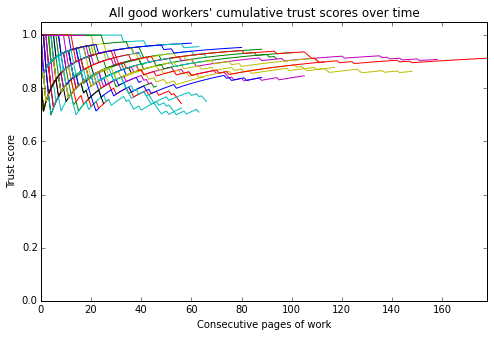

In [38]:
graph = timeres.plot(legend = False, figsize = (8, 5),
            title = "All good workers' cumulative trust scores over time")

graph.set_ylim((0, 1.05))
graph.set_xlabel("Consecutive pages of work")
graph.set_ylabel("Trust score")

### Aggregate results:

In [39]:
raw_res = aggregate_results("uniq_id", "verify_relationship", work_data, "majority_vote",
                        ["pmid", "_unit_id", "chemical_id", "disease_id", "relation_pair_id", "sentence_id"])

In [40]:
raw_res.shape

(4565, 11)

In [41]:
raw_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,sentence_id
0,bcv_final_eval_easy_0,yes_direct,4.5004,5,1.000000,0,773931695,MESH:D015738,MESH:D003693,0_MESH:D015738_MESH:D003693,0_0
0,bcv_final_eval_easy_1,no_relation,4.6655,5,1.000000,0,773931696,MESH:D006632,MESH:D014456,0_MESH:D006632_MESH:D014456,0_1
1,bcv_final_eval_easy_10,yes_direct,3.5427,4,0.802824,2,773931705,MESH:D000305,MESH:D007674,2_MESH:D000305_MESH:D007674,2_4
0,bcv_final_eval_easy_10,no_relation,0.8701,1,0.197176,2,773931705,MESH:D000305,MESH:D007674,2_MESH:D000305_MESH:D007674,2_4
0,bcv_final_eval_easy_100,no_relation,4.2289,5,1.000000,23,773931795,MESH:C029036,MESH:D006949,23_MESH:C029036_MESH:D006949,23_12


In [42]:
raw_res.loc[:, ["pmid", "unit_id"]] = raw_res.loc[:, ["pmid", "unit_id"]].astype(int)

### Were yes_indirect ever a top choice?

In [43]:
indirect_top = set()
for uniq_id, group in raw_res.groupby("uniq_id"):
    if group["verify_relationship"].iloc[0] == "yes_indirect":
        indirect_top.add(uniq_id)
        
print("# of questions where yes_indirect was the top choice: {0}".format(len(indirect_top)))
indirect_top_data = raw_res.query("uniq_id in {0}".format(list(indirect_top)))

# of questions where yes_indirect was the top choice: 12


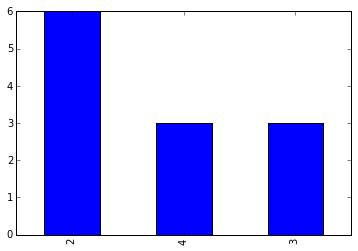

In [44]:
# when yes_indirect was the top answer, how many people voted for it?
indirect_top_data.query("verify_relationship == 'yes_indirect'")["num_votes"].value_counts().plot(kind = 'bar')

### Results where yes_indirect is converted to a no_relation vote:

In [45]:
# take positive votes only, indirect is no
res_pos_no = aggregate_results("uniq_id", "verify_relationship", work_data,
                                    "positive_signal_only",
                                     ["pmid", "_unit_id", "chemical_id", "disease_id", "relation_pair_id", "sentence_id"],
                                    "yes_direct", {"yes_indirect" : "no_relation"})

In [46]:
res_pos_no.shape

(5384, 11)

In [47]:
res_pos_no.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,sentence_id
0,bcv_final_eval_easy_0,yes_direct,4.5004,5,1.000000,0,773931695,MESH:D015738,MESH:D003693,0_MESH:D015738_MESH:D003693,0_0
0,bcv_final_eval_easy_1,yes_direct,0.0000,0,0.000000,0,773931696,MESH:D006632,MESH:D014456,0_MESH:D006632_MESH:D014456,0_1
0,bcv_final_eval_easy_1,no_relation,4.6655,5,1.000000,0,773931696,MESH:D006632,MESH:D014456,0_MESH:D006632_MESH:D014456,0_1
1,bcv_final_eval_easy_10,yes_direct,3.5427,4,0.802824,2,773931705,MESH:D000305,MESH:D007674,2_MESH:D000305_MESH:D007674,2_4
0,bcv_final_eval_easy_10,no_relation,0.8701,1,0.197176,2,773931705,MESH:D000305,MESH:D007674,2_MESH:D000305_MESH:D007674,2_4


In [48]:
res_pos_no.loc[:, ["unit_id", "pmid"]] = res_pos_no.loc[:, ["unit_id", "pmid"]].astype(int)

In [49]:
res_pos_only_no = res_pos_no.query("verify_relationship == 'yes_direct'")

In [50]:
res_pos_only_no.shape

(2940, 11)

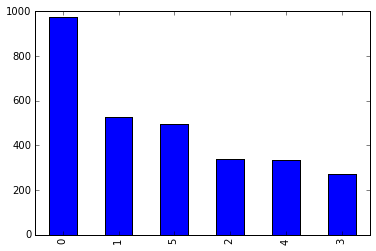

In [51]:
res_pos_only_no["num_votes"].value_counts().plot(kind = "bar")

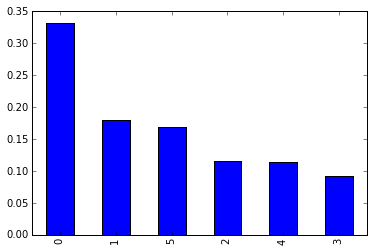

In [52]:
res_pos_only_no["num_votes"].value_counts(normalize = True).plot(kind = "bar")

Again the majority of questions (~50%) were high consensus no_relation answers (4 or 5 votes). A big fraction was also 5/5 yes_direct, or 4/5 yes_direct. Thankfully there were relatively few ambiguous questions (~20%).

In [53]:
res_pos_only_no.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,sentence_id
0,bcv_final_eval_easy_0,yes_direct,4.5004,5,1.000000,0,773931695,MESH:D015738,MESH:D003693,0_MESH:D015738_MESH:D003693,0_0
0,bcv_final_eval_easy_1,yes_direct,0.0000,0,0.000000,0,773931696,MESH:D006632,MESH:D014456,0_MESH:D006632_MESH:D014456,0_1
1,bcv_final_eval_easy_10,yes_direct,3.5427,4,0.802824,2,773931705,MESH:D000305,MESH:D007674,2_MESH:D000305_MESH:D007674,2_4
0,bcv_final_eval_easy_100,yes_direct,0.0000,0,0.000000,23,773931795,MESH:C029036,MESH:D006949,23_MESH:C029036_MESH:D006949,23_12
0,bcv_final_eval_easy_1000,yes_direct,0.0000,0,0.000000,181,773932695,MESH:D006220,MESH:D003643,181_MESH:D006220_MESH:D003643,181_5


### Aggregate sentence level results to the abstract level:

In [54]:
def aggregate_sentences(sentence_res):
    """
    Given the aggregated results at the individual work unit level,
    this function determines which sentence-bound drug-disease relationships
    are true at the abstract level.
    """
    res = defaultdict(list)
    for info, group in sentence_res.groupby(["pmid", "chemical_id", "disease_id"]):
        assert len(group["relation_pair_id"].unique()) == 1
        norm_conf_score_max = group["percent_agree"].max()
        
        res["pmid"].append(info[0])
        res["chemical_id"].append(info[1])
        res["disease_id"].append(info[2])
        
        res["score_vote_max"].append(group["num_votes"].max())
        res["conf_score"].append(norm_conf_score_max)
        
        res["uniq_ids"].append("|".join(group["uniq_id"].unique()))
        res["unit_ids"].append("|".join(map(lambda x: str(int(x)), group["unit_id"].unique())))
        res["sentence_ids"].append("|".join(group["sentence_id"].unique()))
        
    return pd.DataFrame(res)

In [55]:
perf_abs = aggregate_sentences(res_pos_only_no)

In [56]:
perf_abs.shape

(1966, 8)

In [57]:
perf_abs.head()

,chemical_id,conf_score,disease_id,pmid,score_vote_max,sentence_ids,uniq_ids,unit_ids
0,MESH:D006632,0.000000,MESH:D014456,0,0,0_1,bcv_final_eval_easy_1,773931696
1,MESH:D015738,1.000000,MESH:D003693,0,5,0_0|0_2|0_3,bcv_final_eval_easy_0|bcv_final_eval_easy_3|bc...,773931695|773931698|773931699
2,MESH:D015738,0.000000,MESH:D014456,0,0,0_1,bcv_final_eval_easy_2,773931697
3,MESH:D012964,0.189597,MESH:D007022,1,1,1_0,bcv_final_eval_easy_5,773931700
4,MESH:D000305,0.802824,MESH:D007674,2,4,2_4,bcv_final_eval_easy_10,773931705


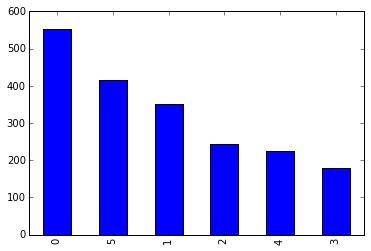

In [58]:
perf_abs["score_vote_max"].value_counts().plot(kind = "bar")

At the abstract level, we see that there are a lot more positive results, mostly because we have combined results together. We will write this to a file for final aggregation.

In [59]:
perf_abs.to_csv("data/final_eval/results/sentence_relation_abs_res.tsv", sep = '\t', index = False)